# Chapter 13 - Data windowing and creating baselines for deep learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import tensorflow as tf


2023-11-14 17:11:25.276879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 17:11:32.522075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)




In [4]:
def plot_time_series_data_window(
  x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

Load datasets (train, val, and test)

In [5]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[section+"_scale_df"] = pd.read_csv(f"./datasets/week-13/{section}_scale.csv",
                                              parse_dates=["date_time"])

dataset["train_scale_df"]

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,0.760019,0.00,0.758755,0.853553,0.146447
1,2016-09-29 18:00:00,0.738174,0.00,0.560765,0.750000,0.066987
2,2016-09-29 19:00:00,0.698884,0.00,0.463513,0.629410,0.017037
3,2016-09-29 20:00:00,0.668238,0.00,0.370029,0.500000,0.000000
4,2016-09-29 21:00:00,0.643093,0.00,0.325101,0.370590,0.017037
...,...,...,...,...,...,...
12280,2018-02-23 09:00:00,0.422599,0.90,0.599972,0.629410,0.982963
12281,2018-02-23 10:00:00,0.421656,0.75,0.561881,0.750000,0.933013
12282,2018-02-23 11:00:00,0.436272,0.90,0.567881,0.853553,0.853553
12283,2018-02-23 12:00:00,0.439415,0.75,0.644482,0.933013,0.750000


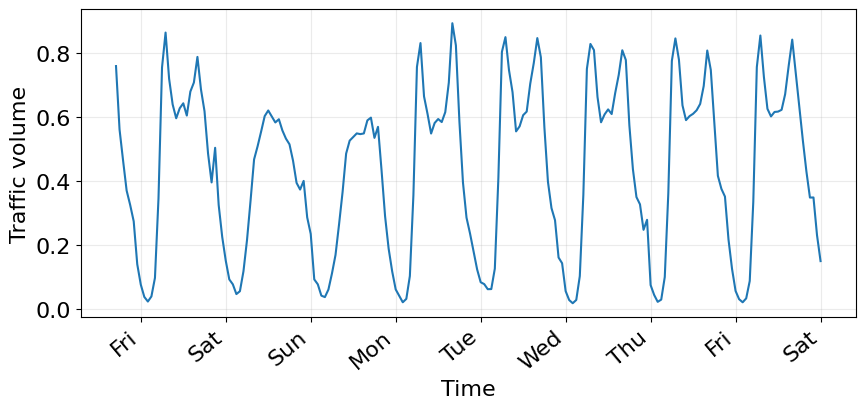

In [6]:
num_of_rows = 200
train_scale_df_selected = dataset["train_scale_df"]
plot_time_series(train_scale_df_selected.iloc[:num_of_rows]["date_time"], 
                  train_scale_df_selected.iloc[:num_of_rows]["traffic_volume"],
                  ylabel="Traffic volume",
                  use_weekday_locator=True, use_year_locator=False)

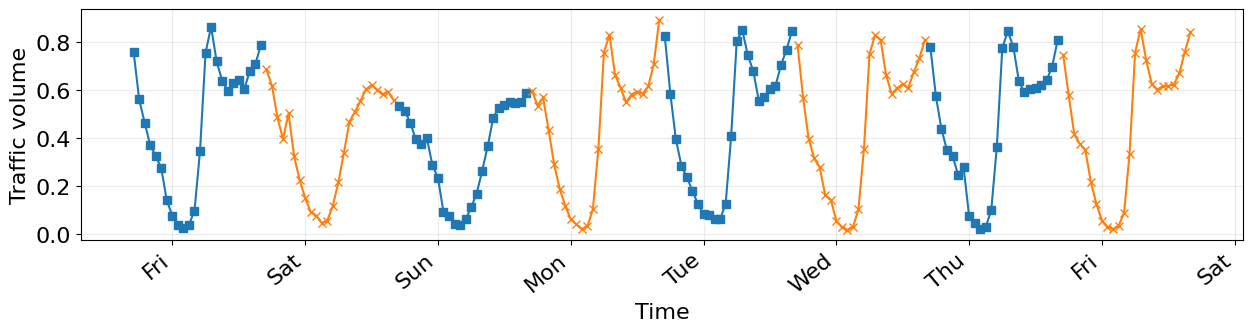

In [7]:
num_of_rows = 200
train_scale_df_selected = dataset["train_scale_df"]
plot_time_series_data_window(train_scale_df_selected.iloc[:num_of_rows]["date_time"], 
                  train_scale_df_selected.iloc[:num_of_rows]["traffic_volume"],
                  ylabel="Traffic volume", figsize=(15, 3),
                  use_weekday_locator=True, use_year_locator=False)


## 13.1 Creating windows of data

We start by creating a `DataWindow` class to make feeding data to the 
deep learning models become easier than without format.    

Our data window will use 25 hours of data to predict the next 24 hours.

In [36]:
class DataWindow(object):
  def __init__(self, input_width, label_width, shift, dataset_dict, 
                label_columns=None, column_to_train=None):
    
    self.train_df = dataset_dict["train_scale_df"]
    self.val_df = dataset_dict["val_scale_df"]
    self.test_df = dataset_dict["test_scale_df"]

    # column that we want to predict
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {
        name: i for i, name in enumerate(label_columns)}
    
    self.column_to_train = column_to_train
    self.column_indices = {name: i for i, name in enumerate(self.column_to_train)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width  # This is equal to self.input_width 
    self.label_slice = slice(self.label_start, None)   # from label_start to the end
                                                       # of self.total_window_size
    self.label_indices = np.arange(self.total_window_size)[self.label_slice]


  def split_to_inputs_labels(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.label_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


  def plot(self, model=None, plot_col="traffic_volume", max_subplots=3):
    inputs, labels = self.sample_batch

    fig, axes = plt.subplots(nrows=max_subplots, ncols=1, figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
      axes[n, 0].plot(self.input_indices, inputs[n, :, plot_col_index],
                      label="Inputs", marker=".", zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      axes[n, 0].scatter(self.label_indices, labels[n, :, label_col_index],
                          edgecolors="k", marker="s", label="Labels",
                          c="green", s=64)
      
      if model is not None:
        predictions = model(inputs)
        axes[n, 0].scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker="X", edgecolor="k", )
          
      
      axes[n, 0].set_ylabel(f"{plot_col} [scaled]")
      axes[n, 0].set_xlabel("Time (h)")
      


  def make_dataset(self, data):
    print(f"self.column_to_train: {self.column_to_train}")
    data = data[self.column_to_train]
    print(f"data: {data}")
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data, targets=None, sequence_length=self.total_window_size, 
      sequence_stride=1, shuffle=True, batch_size=32)
    
    ds = ds.map(self.split_to_inputs_labels)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property 
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def sample_batch(self):
    result = getattr(self, '_sample_batch', None)
    if result is None:
      result = next(iter(self.train))
      self._sample_batch = result
    return result

## 13.2 Applying baseline models

In [37]:
dataset["train_scale_df"]

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,0.760019,0.00,0.758755,0.853553,0.146447
1,2016-09-29 18:00:00,0.738174,0.00,0.560765,0.750000,0.066987
2,2016-09-29 19:00:00,0.698884,0.00,0.463513,0.629410,0.017037
3,2016-09-29 20:00:00,0.668238,0.00,0.370029,0.500000,0.000000
4,2016-09-29 21:00:00,0.643093,0.00,0.325101,0.370590,0.017037
...,...,...,...,...,...,...
12280,2018-02-23 09:00:00,0.422599,0.90,0.599972,0.629410,0.982963
12281,2018-02-23 10:00:00,0.421656,0.75,0.561881,0.750000,0.933013
12282,2018-02-23 11:00:00,0.436272,0.90,0.567881,0.853553,0.853553
12283,2018-02-23 12:00:00,0.439415,0.75,0.644482,0.933013,0.750000


### 13.2.1 Single-step baseline model

In [38]:
single_step_window = DataWindow(1, 1, 1, dataset, label_columns=["traffic_volume"],
                                column_to_train=["temp", "clouds_all", 
                                                  "traffic_volume", "day_sin", "day_cos"])
single_step_window

In [19]:
wide_step_window = DataWindow(24, 24, 1, dataset, label_columns=["traffic_volume"],
                              column_to_train=["temp", "clouds_all", 
                                                  "traffic_volume", "day_sin", "day_cos"])
wide_step_window

In [39]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index 

  def call(self, inputs):
    if self.label_index is None: 
      return inputs 

    elif isinstance(self.label_index, list):
      tensors = []
      for index in self.label_index:
        result = inputs[:, :, index]
        result = result[:, :, tf.newaxis]
      return tf.concat(tensors, axis=-1)
    
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [40]:
column_to_train = ["temp", "clouds_all", "traffic_volume", "day_sin", "day_cos"]
column_indices = {name: i for i, name in enumerate(column_to_train)}

baseline_last = Baseline(label_index=column_indices["traffic_volume"])
baseline_last

In [41]:
baseline_last.compile(
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [42]:
val_performance = {}   # validation
performance = {}    # test set

In [43]:
val_performance["Baseline - Last"] = baseline_last.evaluate(single_step_window.val)
val_performance

self.column_to_train: ['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos']
data:           temp  clouds_all  traffic_volume   day_sin   day_cos
0     0.457646        0.01        0.700153  1.000000  0.500000
1     0.460946        0.20        0.769918  0.982963  0.370590
2     0.459375        0.05        0.872750  0.933013  0.250000
3     0.456388        0.20        0.776894  0.853553  0.146447
4     0.440830        0.05        0.664574  0.750000  0.066987
...        ...         ...             ...       ...       ...
3505  0.805595        0.90        0.780103  0.982963  0.370590
3506  0.796637        0.90        0.885447  0.933013  0.250000
3507  0.794437        0.90        0.803544  0.853553  0.146447
3508  0.783121        0.90        0.611692  0.750000  0.066987
3509  0.770863        0.90        0.461281  0.629410  0.017037

[3510 rows x 5 columns]
110/110 [==============================] - 2s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


{'Baseline - Last': [0.013317279517650604, 0.08305122703313828]}

### 13.2.2 Multi-step baseline model

### 13.2.3 Multi-output baseline model

## 13.3 Next steps

### Additional scripts